In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from statsmodels.graphics.mosaicplot import mosaic
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt, numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
from sklearn import metrics
import warnings
import sys
import random
if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.random.seed(42)

In [35]:
data_events = pd.read_csv("processed_data/processed_events_final.csv", sep="|")
purchase_events = pd.read_csv("processed_data/processed_purchase_events_final.csv", sep="|")


In [196]:
data_events

,TIMESTAMP_EVENT,PRICE,PROPOSITION,USER_CLIENT_NUMBER,ARTICLE_CATEGORIE,USER_SESSION_ID,PROMOTION_LABEL,PAGE_NAME,PAGE_SECTION,PAGE_SECTION_POSITION,...,precipitation_coverage_lead_2,precipitation_amount_lead_2,temperature_lead_3,precipitation_coverage_lead_3,precipitation_amount_lead_3,temperature_lead_4,precipitation_coverage_lead_4,precipitation_amount_lead_4,total_spend_on_category_product,total_spend_on_product
0,2022-02-28 14:51:25.349000+00:00,25.4760,554657,386730,"1,081,511,193",933,Actie,Shopping Cart,Recommended Products,2.0,...,0.0,0.0,2.9,0.0,0.0,1.8,0.0,0.0,0.0,0.00
1,2022-02-28 14:51:46.443000+00:00,25.4760,554657,386730,"1,081,511,193",933,Actie,Shopping Cart,Recommended Products,2.0,...,0.0,0.0,2.9,0.0,0.0,1.8,0.0,0.0,0.0,0.00
2,2022-02-28 14:52:06.207000+00:00,25.4760,554657,386730,"1,081,511,193",933,Actie,Shopping Cart,Recommended Products,2.0,...,0.0,0.0,2.9,0.0,0.0,1.8,0.0,0.0,0.0,0.00
3,2022-02-28 14:52:06.211000+00:00,12.5268,349240,386730,"1,091,661,078",933,Actie,Shopping Cart,Recommended Products,1.0,...,0.0,0.0,2.9,0.0,0.0,1.8,0.0,0.0,0.0,0.00
4,2022-02-28 14:51:25.319000+00:00,12.5268,349240,386730,"1,091,661,078",933,Actie,Shopping Cart,Recommended Products,1.0,...,0.0,0.0,2.9,0.0,0.0,1.8,0.0,0.0,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9935804,2022-01-28 15:48:08.723000+00:00,35.7192,87264,804960,"1,081,451,429",319213,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,196.88
9935805,2022-01-28 15:46:27.480000+00:00,17.1204,594422,804960,"1,011,031,135",319213,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,734.58
9935806,2022-01-28 15:48:43.837000+00:00,18.2424,8749,804960,"1,011,011,555",319213,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,941.96
9935807,2022-01-28 15:48:53.241000+00:00,1.6500,255956,804960,"1,031,161,491",319213,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,61.05


In [36]:
data_events['TIMESTAMP_EVENT'] = pd.to_datetime(data_events['TIMESTAMP_EVENT'])
purchase_events['DATE'] = pd.to_datetime(purchase_events['DATE'])




 Feature Engineering
segmentation:

Recency (R): Time since last purchase.
Frequency (F): Total number of purchases.
Monetary (M): Total spending.

In [169]:
# Group by user and aggregate data
user_data = purchase_events.groupby('USER_CLIENT_NUMBER').agg({
    'DATE': 'max',  # Most recent purchase date
    'PROPOSITION': 'count',  # Frequency of purchases
    'AMOUNT': 'sum'  # Total amount spent
}).rename(columns={'DATE': 'Recent_Purchase_Date', 'PROPOSITION': 'Total_Purchases', 'AMOUNT': 'Total_Spent'})

# Calculate recency in days from the most recent date in the dataset
most_recent_date = purchase_events['DATE'].max()
user_data['Recency'] = (most_recent_date - user_data['Recent_Purchase_Date']).dt.days


In [170]:
user_data

,Recent_Purchase_Date,Total_Purchases,Total_Spent,Recency
USER_CLIENT_NUMBER,,,,
193,2022-04-21,24,2164.09,250
230,2022-04-28,214,8049.98,243
272,2022-04-26,241,6681.66,245
436,2022-04-27,532,16332.51,244
467,2022-03-16,19,611.19,286
...,...,...,...,...
999500,2022-04-26,566,15555.98,245
999513,2022-04-21,38,502.14,250
999551,2022-02-24,3,91.40,306


In [171]:
# Customer Segmentation: quantile-based segmentation method 

# Use quantiles to segment each RFM feature
quantiles = user_data[['Recency', 'Total_Purchases', 'Total_Spent']].quantile(q=[0.25, 0.5, 0.75])
def rfm_segment(x, p, d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]:
        return 3
    else:
        return 4

user_data['R_Score'] = user_data['Recency'].apply(rfm_segment, args=('Recency', quantiles))
user_data['F_Score'] = user_data['Total_Purchases'].apply(rfm_segment, args=('Total_Purchases', quantiles))
user_data['M_Score'] = user_data['Total_Spent'].apply(rfm_segment, args=('Total_Spent', quantiles))


With segmented data, analyze patterns and develop targeted marketing strategies:

High Value Customers: Top RFM scores. Develop loyalty programs or premium offers.
At-Risk Customers: High monetary and frequency scores but low recency score. Re-engage with personalized promotions.
Low-Value Customers: Low scores across RFM. Explore up-sell and cross-sell opportunities to increase their value.

In [172]:
# Define a simple function to assign recommendations based on RFM scores
def assign_recommendations(row):
    if row['R_Score'] == 4 and row['F_Score'] == 4 and row['M_Score'] == 4:
        return 'Premium Product Line'
    elif row['R_Score'] == 1 and row['F_Score'] >= 3:
        return 'Re-engagement Campaign'
    else:
        return 'Regular Promotions'

user_data['Recommendations'] = user_data.apply(assign_recommendations, axis=1)


In [173]:
import json
def save_each_user_in_json_per_recommendation_type(user_data):
    json_data = {
        "Re-engagement Campaign": [],
        "Regular Promotions": [],
        "Premium Product Line": []
    }
    for recommendation_type in user_data['Recommendations'].unique():
        
        json_data[recommendation_type] = user_data[user_data['Recommendations'] == recommendation_type].index.to_list()
        
    return json_data

def write_json_to_file(json_data, file_path):
    with open(file_path, 'w') as f:
        json.dump(json_data, f)
        
        
json_date_recommendations = save_each_user_in_json_per_recommendation_type(user_data)
write_json_to_file(json_date_recommendations, "processed_data/user_recommendations_types.json")

In [174]:
def get_client_data_by_id(client_id):
    
    client_events = pd.read_csv(f"client_data/{str(client_id)}/events.csv", sep="|")
    client_purchase_events = pd.read_csv(f"client_data/{str(client_id)}/purchases.csv", sep="|")
    return client_events, client_purchase_events

def get_client_data_subset_recommendation_type(recommendation_json_clients):
    for recommendation_type, client_id_list in recommendation_json_clients.items():
        for index, client_id in enumerate(client_id_list):
            
            if index == 0:
                all_client_events, all_purchase_events = get_client_data_by_id(client_id)
                continue
                
            client_events, client_purchase_events = get_client_data_by_id(client_id)
            all_client_events = pd.concat([all_client_events, client_events])
            all_purchase_events = pd.concat([all_purchase_events, client_purchase_events])
    return all_client_events, all_purchase_events

#take a subset of clients of each recommendation type
json_data_recommendation_subset = {key: value[:10] for key, value in json_date_recommendations.items()}


all_client_events, all_purchase_events = get_client_data_subset_recommendation_type(json_data_recommendation_subset)
all_client_events


,TIMESTAMP_EVENT,PRICE,PROPOSITION,USER_CLIENT_NUMBER,ARTICLE_CATEGORIE,USER_SESSION_ID,PROMOTION_LABEL,PAGE_NAME,PAGE_SECTION,PAGE_SECTION_POSITION,...,precipitation_coverage_lead_2,precipitation_amount_lead_2,temperature_lead_3,precipitation_coverage_lead_3,precipitation_amount_lead_3,temperature_lead_4,precipitation_coverage_lead_4,precipitation_amount_lead_4,total_spend_on_category_product,total_spend_on_product
0,2021-12-01T13:24:27.131Z,NaN,533300,14061,"1,081,531,502",342,NaN,Shopping Cart,Recommended Products,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
1,2021-12-01T13:24:27.122Z,NaN,210833,14061,"1,051,201,537",342,NaN,Shopping Cart,Recommended Products,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
2,2021-12-01T13:24:27.125Z,NaN,884210,14061,"1,081,531,502",342,NaN,Shopping Cart,Recommended Products,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
3,2021-12-01T13:22:25.391Z,7.3128,96325,14061,"1,091,601,549",342,NaN,Purchaselist,Recommended Products,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
4,2021-12-01T13:23:34.821Z,4.2504,836996,14061,"1,091,541,028",342,NaN,Purchaselist,Recommended Products,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4884,2022-03-21T12:59:17.755Z,NaN,310114,183124,"1,043,111,060",348840,NaN,Shopping Cart,Recommended Products,2.0,...,0.0,0.0,9.4,0.0,0.0,7.9,0.0,0.0,0.0,0.0
4885,2022-03-21T12:59:10.990Z,6.0720,268532,183124,"111,207",348840,NaN,NaN,NaN,NaN,...,0.0,0.0,9.4,0.0,0.0,7.9,0.0,0.0,0.0,0.0
4886,2022-03-21T12:59:14.263Z,6.0720,268532,183124,"111,207",348840,NaN,NaN,NaN,NaN,...,0.0,0.0,9.4,0.0,0.0,7.9,0.0,0.0,0.0,0.0
4887,2022-03-21T12:59:05.634Z,6.0720,268532,183124,"111,207",348840,NaN,NaN,NaN,NaN,...,0.0,0.0,9.4,0.0,0.0,7.9,0.0,0.0,0.0,0.0


In [175]:
# dropping all rows that have page_section_postion as NaN
recommended_products_table = all_client_events[all_client_events["PAGE_SECTION"] =="Recommended Products"]
recommended_products_table["USER_SALES_DISTRICT"].unique()
recommended_products_table

,TIMESTAMP_EVENT,PRICE,PROPOSITION,USER_CLIENT_NUMBER,ARTICLE_CATEGORIE,USER_SESSION_ID,PROMOTION_LABEL,PAGE_NAME,PAGE_SECTION,PAGE_SECTION_POSITION,...,precipitation_coverage_lead_2,precipitation_amount_lead_2,temperature_lead_3,precipitation_coverage_lead_3,precipitation_amount_lead_3,temperature_lead_4,precipitation_coverage_lead_4,precipitation_amount_lead_4,total_spend_on_category_product,total_spend_on_product
0,2021-12-01T13:24:27.131Z,NaN,533300,14061,"1,081,531,502",342,NaN,Shopping Cart,Recommended Products,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.0
1,2021-12-01T13:24:27.122Z,NaN,210833,14061,"1,051,201,537",342,NaN,Shopping Cart,Recommended Products,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.0
2,2021-12-01T13:24:27.125Z,NaN,884210,14061,"1,081,531,502",342,NaN,Shopping Cart,Recommended Products,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.0
3,2021-12-01T13:22:25.391Z,7.3128,96325,14061,"1,091,601,549",342,NaN,Purchaselist,Recommended Products,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.0
4,2021-12-01T13:23:34.821Z,4.2504,836996,14061,"1,091,541,028",342,NaN,Purchaselist,Recommended Products,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4849,2022-03-20T11:41:30.020Z,18.9552,322925,183124,"1,081,531,334",345503,NaN,Shopping Cart,Recommended Products,4.0,...,0.0,0.0,9.7,0.0,0.0,9.4,0.0,0.0,0.00,0.0
4855,2022-03-20T11:41:20.664Z,NaN,974246,183124,"1,101,711,010",345503,NaN,Purchase List,Recommended Products,3.0,...,0.0,0.0,9.7,0.0,0.0,9.4,0.0,0.0,0.00,0.0
4883,2022-03-21T12:59:17.756Z,NaN,500773,183124,"1,091,661,305",348840,NaN,Shopping Cart,Recommended Products,1.0,...,0.0,0.0,9.4,0.0,0.0,7.9,0.0,0.0,144.69,0.0
4884,2022-03-21T12:59:17.755Z,NaN,310114,183124,"1,043,111,060",348840,NaN,Shopping Cart,Recommended Products,2.0,...,0.0,0.0,9.4,0.0,0.0,7.9,0.0,0.0,0.00,0.0


In [176]:
def get_product_session_columns():
    product_specific_features = ["DATE",
                                    "PRICE",
                                    "PROPOSITION",
                                     "ARTICLE_CATEGORIE",
                                     "PAGE_SECTION_POSITION",
                                     "PROMOTION_LABEL",
                                     "PAGE_SECTION",
                                     "PROMOTION_PRICE",
                                     
                                     "USER_PROMOTIONS_ALLOWED",
                                     "total_spend_on_category_product",
                                     "total_spend_on_product"]
    possible_features_session = [
                    
                    "USER_CLIENT_NUMBER",
                    "USER_SESSION_ID",
                    
                    "DEVICE_INFO_BRAND",
                    "DEVICE_INFO_TYPE",
                    "DEVICE_INFO_BROWSER",
                    "USER_SALES_GROUP",
                    "USER_SEGMENT",
                    "USER_SALES_DISTRICT",
                    "temperature",
                    "precipcover",
                    "precip",
                    "temperature_lead_1",
                    "precipitation_coverage_lead_1",
                    "precipitation_amount_lead_1",
                    "temperature_lead_2",
                    "precipitation_coverage_lead_2",
                    "precipitation_amount_lead_2",
                    "temperature_lead_3",
                    "precipitation_coverage_lead_3",
                    "precipitation_amount_lead_3",
                    "temperature_lead_4",
                    "precipitation_coverage_lead_4",
                    "precipitation_amount_lead_4"]
    return product_specific_features, possible_features_session

In [ ]:
def extract_group_session_ranking(client_id):
    
    client_events, client_purchase_events = get_client_data_by_id(436)
    client_events["PAGE_SECTION_POSITION"] = client_events["PAGE_SECTION_POSITION"].fillna(0)
    
    client_events_recommendations =  client_events[client_events["PAGE_SECTION_POSITION"] != 0]
    #transform the time to only to have hours minutes and seconds
    client_events_recommendations["TIME"] = pd.to_datetime(client_events_recommendations["TIMESTAMP_EVENT"]).dt.strftime('%H:%M:%S')
    client_events_recommendations = client_events_recommendations.sort_values(by=["TIME","PAGE_SECTION_POSITION"], ascending=[True, True])
    client_events_recommendations
    
    result[client_id] = {}
    current_group = []
    current_ranking = None
    group_number = 0
    
    passed_days = []
    unique_days = client_events_recommendations["DATE"].unique()
    
    for indx, row in client_events_recommendations.iterrows():
        if row["DATE"] not in passed_days:
            passed_days.append(row["DATE"])
            result[client_id][row["DATE"]] = {"groups": {},
                                              "session_features": ""}
            print(row["DATE"])
        
        
        product_specific_features, possible_features_session = get_product_session_columns()
        
        row_session_related = row[possible_features_session]
        #row_session_related["TIME"] = row_session_related["TIME"].split(".")[0]
        row_product_related = row[product_specific_features]
        ranking = row['PAGE_SECTION_POSITION']
        
                                
        result[client_id][row["DATE"]]["session_features"] = row_session_related.to_dict()
        
        if current_ranking is None or ranking >= current_ranking:
            current_ranking = ranking
            added_group_sess = [{
                "product_features":row_product_related.to_dict(),
            }]
            current_group.append(added_group_sess)
        else:
            result[client_id][row["DATE"]]["groups"][group_number] = current_group
            current_group=[{
                "product_features":row_product_related.to_dict(),
            }]
            current_ranking = ranking
            group_number += 1

In [180]:
def get_features_per_ranking_position(recommended_table, json_recommended_subset):
    """
    Takes all the features that have are on the same ranking order. so it will iterate over the rows. Per user client number, it will go over the rows based on the index order. It will group together all the features that have an increasing ranking order. When the ranking order changes, a new gropu will be created. A Json will be outputted. Per user, the group number key, and the 
    Args:
        recommended_table: 

    Returns:

    """
    result = {}
    for recommendation_type, client_id_list in json_recommended_subset.items():
        for index, client_id in enumerate(client_id_list):
            
            client_events, client_purchase_events = get_client_data_by_id(436)
            client_events["PAGE_SECTION_POSITION"] = client_events["PAGE_SECTION_POSITION"].fillna(0)
            
            client_events_recommendations =  client_events[client_events["PAGE_SECTION_POSITION"] != 0]
            #transform the time to only to have hours minutes and seconds
            client_events_recommendations["TIME"] = pd.to_datetime(client_events_recommendations["TIMESTAMP_EVENT"]).dt.strftime('%H:%M:%S')
            client_events_recommendations = client_events_recommendations.sort_values(by=["TIME","PAGE_SECTION_POSITION"], ascending=[True, True])
            
            
            result[client_id] = {}
            current_group = []
            current_ranking = None
            group_number = 0
            
            passed_days = []
            unique_days = client_events_recommendations["DATE"].unique()
            
            for indx, row in client_events_recommendations.iterrows():
                if row["DATE"] not in passed_days:
                    passed_days.append(row["DATE"])
                    result[client_id][row["DATE"]] = {"groups": {},
                                                      "session_features": ""}
                    print(row["DATE"])
                
                product_specific_features = ["DATE",
                                            "PRICE",
                                            "PROPOSITION",
                                             "ARTICLE_CATEGORIE",
                                             "PAGE_SECTION_POSITION",
                                             "PROMOTION_LABEL",
                                             "PAGE_SECTION",
                                             "PROMOTION_PRICE",
                                             
                                             "USER_PROMOTIONS_ALLOWED",
                                             "total_spend_on_category_product",
                                             "total_spend_on_product",]
                possible_features_session = [
                            
                            "USER_CLIENT_NUMBER",
                            "USER_SESSION_ID",
                            
                            "DEVICE_INFO_BRAND",
                            "DEVICE_INFO_TYPE",
                            "DEVICE_INFO_BROWSER",
                            "USER_SALES_GROUP",
                            "USER_SEGMENT",
                            "USER_SALES_DISTRICT",
                            "temperature",
                            "precipcover",
                            "precip",
                            "temperature_lead_1",
                            "precipitation_coverage_lead_1",
                            "precipitation_amount_lead_1",
                            "temperature_lead_2",
                            "precipitation_coverage_lead_2",
                            "precipitation_amount_lead_2",
                            "temperature_lead_3",
                            "precipitation_coverage_lead_3",
                            "precipitation_amount_lead_3",
                            "temperature_lead_4",
                            "precipitation_coverage_lead_4",
                            "precipitation_amount_lead_4",
                            
                        ]
                
                
                row_session_related = row[possible_features_session]
                #row_session_related["TIME"] = row_session_related["TIME"].split(".")[0]
                row_product_related = row[product_specific_features]
                ranking = row['PAGE_SECTION_POSITION']
                
                                        
                result[client_id][row["DATE"]]["session_features"] = row_session_related.to_dict()
                
                if current_ranking is None or ranking >= current_ranking:
                    current_ranking = ranking
                    added_group_sess = [{
                        "product_features":row_product_related.to_dict(),
                    }]
                    current_group.append(added_group_sess)
                else:
                    result[client_id][row["DATE"]]["groups"][group_number] = current_group
                    current_group=[{
                        "product_features":row_product_related.to_dict(),
                    }]
                    current_ranking = ranking
                    group_number += 1
    return result


json_groups = get_features_per_ranking_position(recommended_products_table, json_data_recommendation_subset)

2022-04-22
2022-03-30
2022-03-03
2022-02-01
2022-02-15
2022-01-19
2021-12-01
2022-04-13
2022-03-10
2021-12-08
2022-03-17
2022-04-22
2022-03-30
2022-03-03
2022-02-01
2022-02-15
2022-01-19
2021-12-01
2022-04-13
2022-03-10
2021-12-08
2022-03-17
2022-04-22
2022-03-30
2022-03-03
2022-02-01
2022-02-15
2022-01-19
2021-12-01
2022-04-13
2022-03-10
2021-12-08
2022-03-17
2022-04-22
2022-03-30
2022-03-03
2022-02-01
2022-02-15
2022-01-19
2021-12-01
2022-04-13
2022-03-10
2021-12-08
2022-03-17
2022-04-22
2022-03-30
2022-03-03
2022-02-01
2022-02-15
2022-01-19
2021-12-01
2022-04-13
2022-03-10
2021-12-08
2022-03-17
2022-04-22
2022-03-30
2022-03-03
2022-02-01
2022-02-15
2022-01-19
2021-12-01
2022-04-13
2022-03-10
2021-12-08
2022-03-17
2022-04-22
2022-03-30
2022-03-03
2022-02-01
2022-02-15
2022-01-19
2021-12-01
2022-04-13
2022-03-10
2021-12-08
2022-03-17
2022-04-22
2022-03-30
2022-03-03
2022-02-01
2022-02-15
2022-01-19
2021-12-01
2022-04-13
2022-03-10
2021-12-08
2022-03-17
2022-04-22
2022-03-30
2022-03-03

In [178]:
json_data_recommendation_subset

{'Re-engagement Campaign': [436,
  545,
  1423,
  1489,
  1544,
  1597,
  1780,
  1923,
  2005,
  2288],
 'Regular Promotions': [193, 230, 272, 467, 500, 549, 695, 706, 716, 840],
 'Premium Product Line': [14061,
  22581,
  70951,
  91935,
  108385,
  131998,
  139557,
  158320,
  176301,
  183124]}

In [141]:
client_events, client_purchase_events = get_client_data_by_id(436)
client_events[client_events["USER_CLIENT_NUMBER"]==436]

,TIMESTAMP_EVENT,PRICE,PROPOSITION,USER_CLIENT_NUMBER,ARTICLE_CATEGORIE,USER_SESSION_ID,PROMOTION_LABEL,PAGE_NAME,PAGE_SECTION,PAGE_SECTION_POSITION,...,precipitation_coverage_lead_2,precipitation_amount_lead_2,temperature_lead_3,precipitation_coverage_lead_3,precipitation_amount_lead_3,temperature_lead_4,precipitation_coverage_lead_4,precipitation_amount_lead_4,total_spend_on_category_product,total_spend_on_product
0,2022-03-30T10:35:31.558Z,2.7324,824142,436,"1,061,281,249",38840,NaN,Purchase List,Recommended Products,4.0,...,58.33,6.863,-0.3,0.0,0.000,0.2,12.50,0.042,0.00,0.00
1,2022-03-30T10:35:35.345Z,14.5992,574497,436,"1,091,601,549",38840,NaN,Purchase List,Recommended Products,9.0,...,58.33,6.863,-0.3,0.0,0.000,0.2,12.50,0.042,0.00,0.00
2,2022-03-30T10:35:39.360Z,30.2544,959996,436,"1,071,331,345",38840,NaN,Purchase List,Recommended Products,15.0,...,58.33,6.863,-0.3,0.0,0.000,0.2,12.50,0.042,0.00,0.00
3,2022-03-30T10:35:39.173Z,28.0236,744602,436,"1,091,631,030",38840,NaN,Purchase List,Recommended Products,14.0,...,58.33,6.863,-0.3,0.0,0.000,0.2,12.50,0.042,0.00,0.00
4,2022-03-30T10:35:38.994Z,7.6560,760219,436,"1,031,171,541",38840,NaN,Purchase List,Recommended Products,13.0,...,58.33,6.863,-0.3,0.0,0.000,0.2,12.50,0.042,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
620,2022-04-22T07:50:14.378Z,21.3444,593499,436,"1,101,761,000",340816,NaN,NaN,NaN,NaN,...,4.17,0.006,7.1,25.0,2.549,8.6,4.17,0.003,168.72,168.72
621,2022-04-22T07:44:39.796Z,22.0836,611547,436,"1,051,191,437",340816,NaN,NaN,NaN,NaN,...,4.17,0.006,7.1,25.0,2.549,8.6,4.17,0.003,228.48,228.48
622,2022-04-22T07:48:39.353Z,6.2040,649538,436,"1,091,641,303",340816,NaN,NaN,NaN,NaN,...,4.17,0.006,7.1,25.0,2.549,8.6,4.17,0.003,145.32,90.67
623,2022-04-22T07:48:21.745Z,22.5324,102140,436,"1,091,621,316",340816,NaN,NaN,NaN,NaN,...,4.17,0.006,7.1,25.0,2.549,8.6,4.17,0.003,326.00,326.00


In [192]:
json_groups.keys()

dict_keys([436, 545, 1423, 1489, 1544, 1597, 1780, 1923, 2005, 2288, 193, 230, 272, 467, 500, 549, 695, 706, 716, 840, 14061, 22581, 70951, 91935, 108385, 131998, 139557, 158320, 176301, 183124])

In [194]:
with open("test.json", "w") as f:
    f.write(json.dumps(json_groups, indent=4))

print(json.dumps(json_groups[22581],indent=4))

{
    "2022-04-22": {
        "groups": {
            "0": [
                [
                    {
                        "product_features": {
                            "DATE": "2022-04-22",
                            "PRICE": 32.7624,
                            "PROPOSITION": 715578,
                            "ARTICLE_CATEGORIE": "1,071,331,581",
                            "PAGE_SECTION_POSITION": 1.0,
                            "PROMOTION_LABEL": NaN,
                            "PAGE_SECTION": "Recommended Products",
                            "PROMOTION_PRICE": NaN,
                            "USER_PROMOTIONS_ALLOWED": 1,
                            "total_spend_on_category_product": 0.0,
                            "total_spend_on_product": 0.0
                        }
                    }
                ],
                [
                    {
                        "product_features": {
                            "DATE": "2022-04-22",
                       

In [99]:
len(json_groups[436][8])

4

In [44]:
# print amount in each category
for key, value in json_date_recommendations.items():
    print(key, len(value))

Re-engagement Campaign 3685
Regular Promotions 6972
Premium Product Line 54


In [195]:
json_data_recommendation_subset

{'Re-engagement Campaign': [436,
  545,
  1423,
  1489,
  1544,
  1597,
  1780,
  1923,
  2005,
  2288],
 'Regular Promotions': [193, 230, 272, 467, 500, 549, 695, 706, 716, 840],
 'Premium Product Line': [14061,
  22581,
  70951,
  91935,
  108385,
  131998,
  139557,
  158320,
  176301,
  183124]}

In [11]:
contexts = user_data[['R_Score', 'F_Score', 'M_Score']].values  
actions = user_data['Recommendations']  
rewards = user_data['Total_Spent'] > user_data['Total_Spent'].quantile(0.75)  # High spend as a reward signal

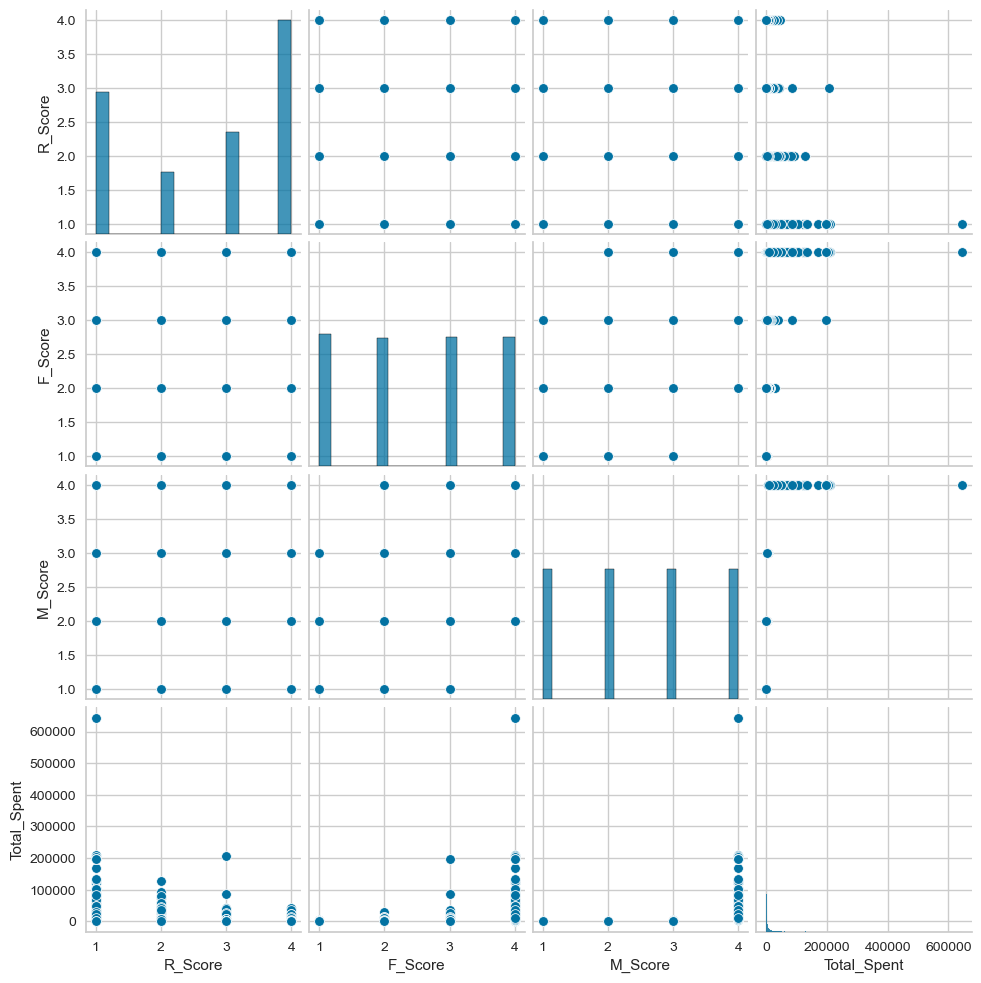

              R_Score   F_Score   M_Score  Total_Spent
R_Score      1.000000 -0.749983 -0.740586    -0.352499
F_Score     -0.749983  1.000000  0.888690     0.410046
M_Score     -0.740586  0.888690  1.000000     0.428232
Total_Spent -0.352499  0.410046  0.428232     1.000000


In [12]:
# policy 
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame containing the RFM scores and total spending
sns.pairplot(user_data[['R_Score', 'F_Score', 'M_Score', 'Total_Spent']])
plt.show()

# Correlation matrix
print(user_data[['R_Score', 'F_Score', 'M_Score', 'Total_Spent']].corr())


In [15]:
user_data['Recommendations'].unique()

array(['Regular Promotions', 'Re-engagement Campaign',
       'Premium Product Line'], dtype=object)

In [35]:
# ContextualEpsilonGreedyBandit
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

class ContextualEpsilonGreedyBandit:
    def __init__(self, epsilon, n_actions):
        self.epsilon = epsilon
        self.n_actions = n_actions
        self.context_action_counts = {}
        self.context_action_values = {}
        self.cumulative_rewards = 0
        self.cumulative_regrets = 0
        self.total_actions_taken = 0
        self.mean_rewards = []
        self.mean_regrets = []

    def get_context_key(self, context):
        return tuple(context)

    def select_action(self, context):
        context_key = self.get_context_key(context)
        if np.random.random() < self.epsilon:
            return np.random.randint(self.n_actions)
        else:
            if context_key in self.context_action_values:
                return np.argmax(self.context_action_values[context_key])
            else:
                return np.random.randint(self.n_actions)

    def update(self, context, action, reward, optimal_reward):
        context_key = self.get_context_key(context)
        if context_key not in self.context_action_counts:
            self.context_action_counts[context_key] = np.zeros(self.n_actions)
            self.context_action_values[context_key] = np.zeros(self.n_actions)

        # Update action count and values
        self.context_action_counts[context_key][action] += 1
        n = self.context_action_counts[context_key][action]
        value = self.context_action_values[context_key][action]
        self.context_action_values[context_key][action] += (reward - value) / n

        # Track performance
        self.cumulative_rewards += reward
        self.cumulative_regrets += optimal_reward - reward
        self.total_actions_taken += 1
        self.mean_rewards.append(self.cumulative_rewards / self.total_actions_taken)
        self.mean_regrets.append(self.cumulative_regrets / self.total_actions_taken)

# Initialize the bandit
encoder = LabelEncoder()
encoded_actions = encoder.fit_transform(user_data['Recommendations'])
action_names = encoder.classes_
n_actions = len(np.unique(encoded_actions))
contexts = user_data[['R_Score', 'F_Score', 'M_Score']].values
rewards = (user_data['Total_Spent'] > user_data['Total_Spent'].quantile(0.75)).astype(int)
optimal_rewards = np.max(rewards)  # Assuming the optimal reward is the max reward possible

bandit = ContextualEpsilonGreedyBandit(epsilon=0.1, n_actions=n_actions)

# Update bandit with historical data
for context, action, reward in zip(contexts, encoded_actions, rewards):
    optimal_reward = optimal_rewards  # For simplification, assume the optimal reward is static
    bandit.update(context, action, reward, optimal_reward)


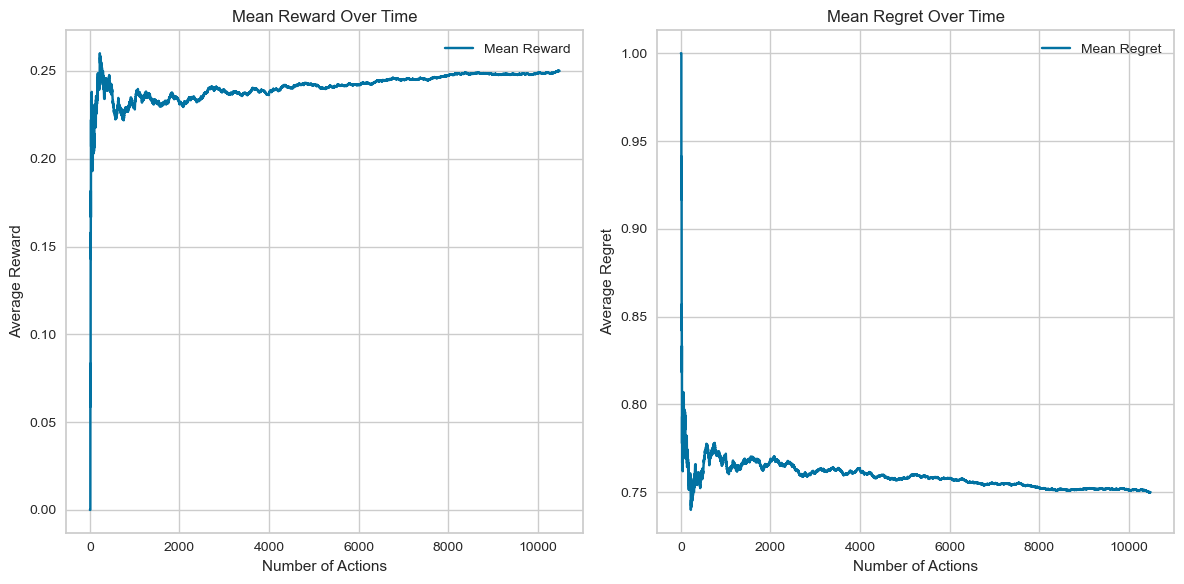

In [29]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(bandit.mean_rewards, label='Mean Reward')
plt.title('Mean Reward Over Time')
plt.xlabel('Number of Actions')
plt.ylabel('Average Reward')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(bandit.mean_regrets, label='Mean Regret')
plt.title('Mean Regret Over Time')
plt.xlabel('Number of Actions')
plt.ylabel('Average Regret')
plt.legend()

plt.tight_layout()
plt.show()


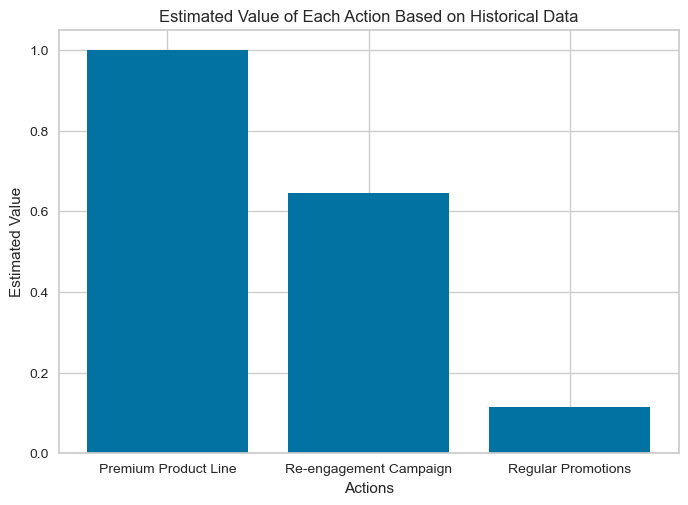

In [17]:
import matplotlib.pyplot as plt

# Plotting the rewards
plt.bar(action_names, bandit.action_rewards)
plt.xlabel('Actions')
plt.ylabel('Estimated Value')
plt.title('Estimated Value of Each Action Based on Historical Data')
plt.show()


In [38]:
# # ContextualThompsonSamplingBandit

import numpy as np
from scipy.stats import beta as beta_dist 
from sklearn.preprocessing import LabelEncoder

class ContextualThompsonSamplingBandit:
    def __init__(self, n_actions):
        self.n_actions = n_actions
        self.params = {}  # stores alpha and beta for each context and action

    def get_context_key(self, context):
        # Convert context array to a tuple to use as a dictionary key
        return tuple(context)

    def ensure_context_initialized(self, context_key):
        # Initialize with uniform priors if not already initialized
        if context_key not in self.params:
            self.params[context_key] = [(1, 1) for _ in range(self.n_actions)]

    def select_action(self, context):
        context_key = self.get_context_key(context)
        self.ensure_context_initialized(context_key)

        # Debug print to check the structure of self.params[context_key]
        print(f"Params for {context_key}: {self.params[context_key]}")

        # Sample from the Beta distribution for each action
        samples = [beta_dist.rvs(alpha, beta) for alpha, beta in self.params[context_key]]
        return np.argmax(samples)

    def update(self, context, action, reward):
        context_key = self.get_context_key(context)
        self.ensure_context_initialized(context_key)
        alpha, beta = self.params[context_key][action]
        self.params[context_key][action] = (alpha + reward, beta + 1 - reward)


encoder = LabelEncoder()
encoded_actions = encoder.fit_transform(user_data['Recommendations'])
action_names = encoder.classes_
contexts = user_data[['R_Score', 'F_Score', 'M_Score']].values
rewards = (user_data['Total_Spent'] > user_data['Total_Spent'].quantile(0.75)).astype(int)
n_actions = len(np.unique(encoded_actions))

bandit = ContextualThompsonSamplingBandit(n_actions=n_actions)

# Simulate bandit updates
cumulative_rewards = 0
for context, action, reward in zip(contexts, encoded_actions, rewards):
    chosen_action = bandit.select_action(context)
    actual_reward = reward if action == chosen_action else 0
    bandit.update(context, chosen_action, actual_reward)
    cumulative_rewards += actual_reward

print("Final Cumulative Reward:", cumulative_rewards)


Params for (4, 1, 1): [(1, 1), (1, 1), (1, 1)]
Params for (1, 3, 2): [(1, 1), (1, 1), (1, 1)]
Params for (4, 1, 1): [(1, 1), (1, 1), (1, 2)]
Params for (3, 3, 2): [(1, 1), (1, 1), (1, 1)]
Params for (4, 1, 1): [(1, 1), (1, 1), (1, 3)]
Params for (4, 2, 2): [(1, 1), (1, 1), (1, 1)]
Params for (3, 3, 2): [(1, 1), (1, 2), (1, 1)]
Params for (4, 2, 3): [(1, 1), (1, 1), (1, 1)]
Params for (2, 3, 2): [(1, 1), (1, 1), (1, 1)]
Params for (2, 3, 3): [(1, 1), (1, 1), (1, 1)]
Params for (4, 1, 2): [(1, 1), (1, 1), (1, 1)]
Params for (4, 3, 4): [(1, 1), (1, 1), (1, 1)]
Params for (4, 1, 1): [(1, 2), (1, 1), (1, 3)]
Params for (3, 3, 3): [(1, 1), (1, 1), (1, 1)]
Params for (1, 1, 2): [(1, 1), (1, 1), (1, 1)]
Params for (4, 1, 1): [(1, 2), (1, 2), (1, 3)]
Params for (3, 2, 2): [(1, 1), (1, 1), (1, 1)]
Params for (1, 4, 4): [(1, 1), (1, 1), (1, 1)]
Params for (1, 4, 4): [(1, 1), (1, 1), (1, 2)]
Params for (1, 4, 3): [(1, 1), (1, 1), (1, 1)]
Params for (1, 2, 2): [(1, 1), (1, 1), (1, 1)]
Params for (1

In [ ]:
ContextualThompsonSamplingBandit = np.mean(cumulative_rewards, axis=0)
linucb_mean_cum_regret = np.mean(cum_regret, axis=0)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(bandit.mean_rewards, label='Mean Reward')
plt.title('Mean Reward Over Time')
plt.xlabel('Number of Actions')
plt.ylabel('Average Reward')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(bandit.cumulative_regrets, label='Cumulative Regret')
plt.title('Cumulative Regret Over Time')
plt.xlabel('Number of Actions')
plt.ylabel('Regret')
plt.legend()

plt.tight_layout()
plt.show()


In [19]:
# Assuming actions and rewards are already defined in user_data
encoder = LabelEncoder()
encoded_actions = encoder.fit_transform(user_data['Recommendations'])
action_names = encoder.classes_

# Rewards should be binary; assuming it's already the case based on the previous context


In [20]:
# Initialize bandit
n_actions = len(np.unique(encoded_actions))
bandit = ThompsonSamplingBandit(n_actions=n_actions)

# Historical update
for action, reward in zip(encoded_actions, user_data['Total_Spent'] > user_data['Total_Spent'].quantile(0.75)):
    bandit.update(action, int(reward))


In [21]:
# evaluation
# Variables to track performance
cumulative_reward = 0
num_actions_taken = 0
optimal_action_rewards = np.zeros(n_actions)

# Find the best action in hindsight
optimal_action = np.argmax(rewards.groupby(encoded_actions).mean())

# Simulation for offline evaluation
for action, reward in zip(encoded_actions, rewards):
    chosen_action = bandit.select_action()
    actual_reward = reward if action == chosen_action else 0
    bandit.update(chosen_action, actual_reward)
    cumulative_reward += actual_reward
    optimal_action_rewards[optimal_action] += reward

# Calculate regret
total_optimal_reward = sum(optimal_action_rewards)
regret = total_optimal_reward - cumulative_reward

# Output results
print("Cumulative Reward:", cumulative_reward)
print("Total Optimal Reward:", total_optimal_reward)
print("Regret:", regret)

Cumulative Reward: 1622
Total Optimal Reward: 2621.0
Regret: 999.0


In [22]:

for action, reward in zip(encoded_actions, rewards):
    chosen_action = bandit.select_action()
    actual_reward = reward if action == chosen_action else 0
    bandit.update(chosen_action, actual_reward)
    cumulative_reward += actual_reward
    num_actions_taken += 1

# Calculate average reward
average_reward = cumulative_reward / num_actions_taken if num_actions_taken > 0 else 0

# Output results
print("Cumulative Reward:", cumulative_reward)
print("Average Reward:", average_reward)

Cumulative Reward: 3267
Average Reward: 0.31161770316673026


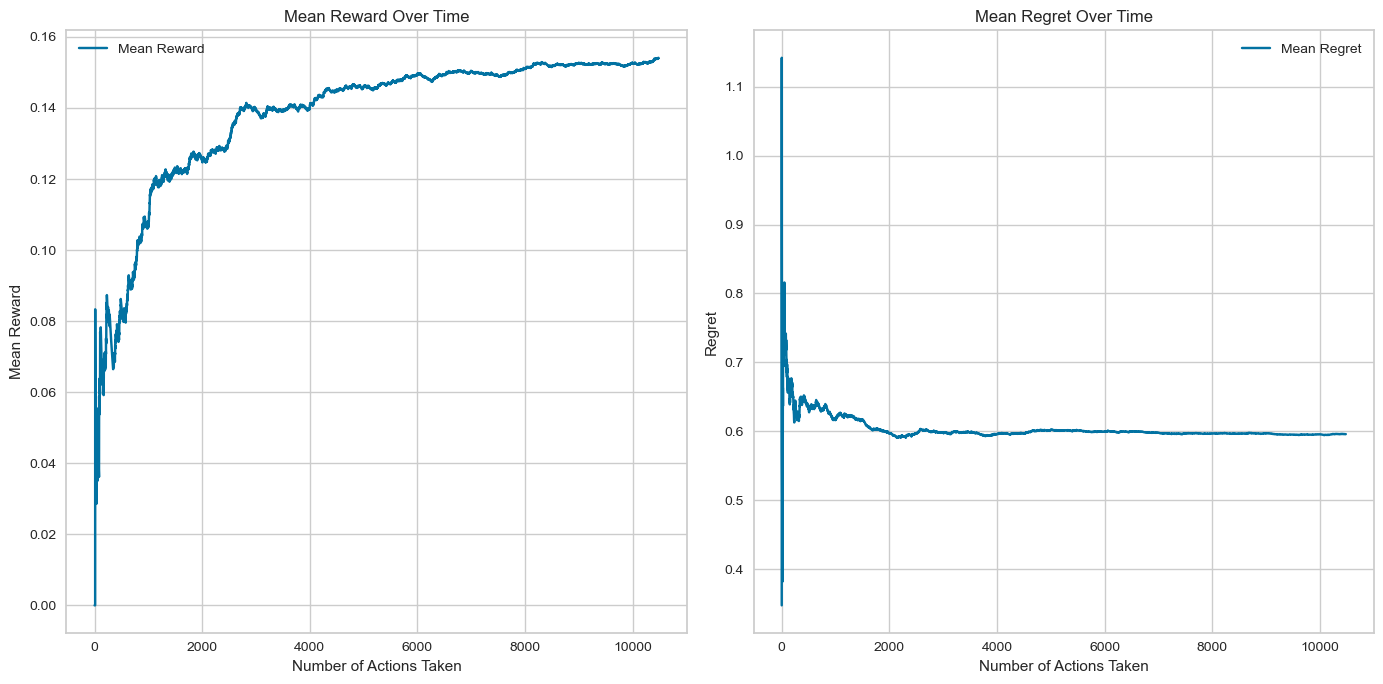

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta
from sklearn.preprocessing import LabelEncoder

# Assuming 'user_data' and other required data setups are previously defined
encoder = LabelEncoder()
encoded_actions = encoder.fit_transform(user_data['Recommendations'])
action_names = encoder.classes_
rewards = user_data['Total_Spent'] > user_data['Total_Spent'].quantile(0.75)

class ThompsonSamplingBandit:
    def __init__(self, n_actions):
        self.alphas = np.ones(n_actions)
        self.betas = np.ones(n_actions)

    def select_action(self):
        samples = [beta.rvs(a, b) for a, b in zip(self.alphas, self.betas)]
        return np.argmax(samples)

    def update(self, action, reward):
        self.alphas[action] += reward
        self.betas[action] += (1 - reward)

# Initialize bandit
n_actions = len(np.unique(encoded_actions))
bandit = ThompsonSamplingBandit(n_actions=n_actions)

# Variables to track performance
cumulative_reward = 0
num_actions_taken = 0
optimal_action_rewards = np.zeros(n_actions)
mean_rewards = []
regrets = []
mean_regrets = []


for i, (action, reward) in enumerate(zip(encoded_actions, rewards)):
    chosen_action = bandit.select_action()
    actual_reward = reward if action == chosen_action else 0
    bandit.update(chosen_action, actual_reward)
    cumulative_reward += actual_reward
    num_actions_taken += 1
    
    # Update mean rewards
    mean_reward = cumulative_reward / num_actions_taken
    mean_rewards.append(mean_reward)
    
    # Update regrets for calculating mean regret
    optimal_reward = rewards[encoded_actions == action].mean()  # Estimated optimal reward for the action
    optimal_action_rewards += optimal_reward
    regret = np.sum(optimal_action_rewards) - cumulative_reward
    regrets.append(regret)
    mean_regret = regret / num_actions_taken
    mean_regrets.append(mean_regret)

# Plotting results
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.plot(mean_rewards, label='Mean Reward')
plt.title('Mean Reward Over Time')
plt.xlabel('Number of Actions Taken')
plt.ylabel('Mean Reward')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(mean_regrets, label='Mean Regret')
plt.title('Mean Regret Over Time')
plt.xlabel('Number of Actions Taken')
plt.ylabel('Regret')
plt.legend()

plt.tight_layout()
plt.show()
